# Implementación de ResNet

En este ejercicio práctico vamos a implementar una red neuronal con conexiones residuales y vamos a probar como dichas conexiones evitan que la performance se degrade al aumentar las capas de la red neuronal.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchsummary

Para este caso, vamos a entrenar a las redes neuronales para que aproximen la función seno, por lo que vamos a generar datos utilizando dicha función. El dataset esta generado en una clase propia, que hereda de la clase base Dataset que provee PyTorch. Para crear un dataset de esta forma, es necesario implementar los metodos `__len__` y `__getitem__`. Ver [ejemplo](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

device

'cuda'

In [3]:
class SinDataset(torch.utils.data.Dataset):
    def __init__(self, mean, stddev):
        self.mean = mean
        self.stddev = stddev

        self.data = np.random.normal(loc=self.mean, scale=self.stddev, size=(640, 10)).astype(np.float32)
        self.target = np.sin(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, id):
        if torch.is_tensor(id):
            id = id.tolist()

        data = self.data[id]
        target = self.target[id]

        return (data, target)

In [4]:
train_set = SinDataset(np.pi, 1.5)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

## ResNet vs Red "plana"

Con el objetivo de probar el funcionamiento de las conexiones residuales, generamos modelos "planos", es decir, sin dichas conexiones y los entrenamos aumentando cada vez mas la cantidad de capas densas en los mismos. Luego, repetimos el proceso para modelos de iguales cantidades de capas pero agregando las conexiones residuales. Finalmente comparamos la evolución del error al final del entrenamiento, a medida que se van incrementando la cantidad de capas, para ambos casos.


In [5]:
# Defino la cantidad de capas que quiero que tenga la red mas grande
layers_amount = 25

### Entrenamiento red "plana"

In [6]:
class PlainModel(torch.nn.Module):
    def __init__(self, layers, input_size):
        super().__init__()
        
        self.first_layer = torch.nn.Linear(in_features=input_size, out_features=10)
        self.hidden_layers = torch.nn.ModuleList()
        for i in range(layers-1):
            self.hidden_layers.append(torch.nn.Linear(in_features=10, out_features=10))

    def forward(self, x):

        x = torch.relu(self.first_layer(x))
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        return x

In [7]:
plain_model = PlainModel(layers=5, input_size=10)
plain_model.to(device)
torchsummary.summary(plain_model, input_size=(1, 10))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 10]             110
            Linear-2                [-1, 1, 10]             110
            Linear-3                [-1, 1, 10]             110
            Linear-4                [-1, 1, 10]             110
            Linear-5                [-1, 1, 10]             110
Total params: 550
Trainable params: 550
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [10]:
# Funcion de entrenamiento

def train(model, data_loader, epochs):

    optimizer = torch.optim.Adam(model.parameters())
    loss = torch.nn.MSELoss()

    model.to(device)

    for epoch in range(epochs):

        epoch_loss = 0.0
        for data, target in data_loader:

            data = data.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss_value = loss(output, target)
            epoch_loss += loss_value.item()
            loss_value.backward()
            optimizer.step()

    last_epoch_loss = epoch_loss / len(data_loader)
    print("Error de ultima epoca es {}".format(last_epoch_loss))
    return last_epoch_loss

In [11]:
print("Entrenamiento redes neuronales planas")

plain_loss_history = []

for layers in range(1, layers_amount):

    plain_model = PlainModel(layers=layers, input_size=10)
    plain_loss = train(plain_model, train_loader, 20*layers)
    plain_loss_history.append(plain_loss)
    del plain_model

Entrenamiento redes neuronales planas
Error de ultima epoca es 0.4909973621368408
Error de ultima epoca es 0.4223707839846611
Error de ultima epoca es 0.4356062367558479
Error de ultima epoca es 0.39638872146606446
Error de ultima epoca es 0.3789876252412796
Error de ultima epoca es 0.4250675529241562
Error de ultima epoca es 0.42560378462076187
Error de ultima epoca es 0.4387815997004509
Error de ultima epoca es 0.4104364663362503
Error de ultima epoca es 0.42933314144611356
Error de ultima epoca es 0.4456554129719734
Error de ultima epoca es 0.4337141066789627
Error de ultima epoca es 0.44526342302560806
Error de ultima epoca es 0.43086577504873275
Error de ultima epoca es 0.44721354693174364
Error de ultima epoca es 0.4305615559220314
Error de ultima epoca es 0.45523177832365036
Error de ultima epoca es 0.4249104902148247
Error de ultima epoca es 0.4610721588134766
Error de ultima epoca es 0.44847880601882933
Error de ultima epoca es 0.4893661722540855
Error de ultima epoca es 0.446

### Entrenamiento de ResNet

In [12]:
class ResNetBlock(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        
        self.layer1 = torch.nn.Linear(in_features, out_features)
        self.layer2 = torch.nn.Linear(in_features, out_features)

    def forward(self, x):

        shortcut = x
        x = torch.relu(self.layer1(x))
        x = self.layer2(x)
        x = shortcut + x
        x = torch.relu(x)
        return x

class ResNetModel(torch.nn.Module):
    def __init__(self, layers, input_size, resnet_block):
        super().__init__()
        
        self.first_layer = torch.nn.Linear(in_features=input_size, out_features=10)
        self.hidden_layers = torch.nn.ModuleList()
        for i in range(int((layers-1)/2)):
            self.hidden_layers.append(resnet_block(in_features=10, out_features=10))

    def forward(self, x):

        x = torch.relu(self.first_layer(x))
        for layer in self.hidden_layers:
            x = layer(x)
        return x

In [13]:
resnet_model = ResNetModel(layers=5, input_size=10, resnet_block=ResNetBlock)
resnet_model.to(device)
torchsummary.summary(resnet_model, input_size=(1, 10))
print(resnet_model.modules)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 10]             110
            Linear-2                [-1, 1, 10]             110
            Linear-3                [-1, 1, 10]             110
       ResNetBlock-4                [-1, 1, 10]               0
            Linear-5                [-1, 1, 10]             110
            Linear-6                [-1, 1, 10]             110
       ResNetBlock-7                [-1, 1, 10]               0
Total params: 550
Trainable params: 550
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
<bound method Module.modules of ResNetModel(
  (first_layer): Linear(in_features=10, out_features=10, bias=True)
 

In [14]:
print("Entrenamiento redes neuronales residuales")

resnet_loss_history = []

for layers in range(1, layers_amount):

    resnet_model = ResNetModel(layers=layers, input_size=10, resnet_block=ResNetBlock)
    resnet_loss = train(resnet_model, train_loader, 20*layers)
    resnet_loss_history.append(resnet_loss)
    del resnet_model

Entrenamiento redes neuronales residuales
Error de ultima epoca es 0.48412264585494996
Error de ultima epoca es 0.48625043481588365
Error de ultima epoca es 0.4566889390349388
Error de ultima epoca es 0.45583823770284654
Error de ultima epoca es 0.4027260929346085
Error de ultima epoca es 0.4295657604932785
Error de ultima epoca es 0.3958780750632286
Error de ultima epoca es 0.429124142229557
Error de ultima epoca es 0.369241988658905
Error de ultima epoca es 0.367106531560421
Error de ultima epoca es 0.37546236962080004
Error de ultima epoca es 0.39831882864236834
Error de ultima epoca es 0.36823626309633256
Error de ultima epoca es 0.34073369950056076
Error de ultima epoca es 0.35388671010732653
Error de ultima epoca es 0.35320334881544113
Error de ultima epoca es 0.3336495116353035
Error de ultima epoca es 0.3462317153811455
Error de ultima epoca es 0.3486809492111206
Error de ultima epoca es 0.3480807989835739
Error de ultima epoca es 0.32600062638521193
Error de ultima epoca es 0.

## Grafica con los resultados

En la siguiente grafica se puede observar como evoluciona el error de entrenamiento a medida que se incrementa la cantidad de capas dentro de la red.

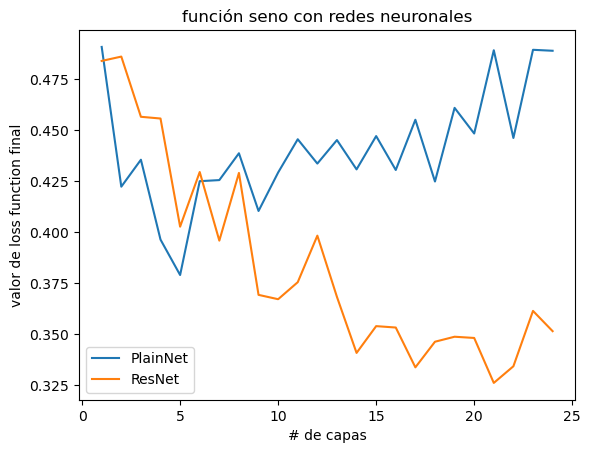

In [15]:
plt.plot(range(1, layers_amount), plain_loss_history, label="PlainNet")
plt.plot(range(1, layers_amount), resnet_loss_history, label="ResNet")
plt.title("función seno con redes neuronales")
plt.xlabel("# de capas")
plt.ylabel("valor de loss function final")
plt.legend()
plt.show()